This notebook will be used to see which supervised learning model will be best for predicting the weather using information like precipitation, max temperature, min temperature, and wind. The models tested will be logisitic regression, decision tree, K nearest neighbor (KNN), random forest, and support vector classification. For comparing model performance, accruacy, recall, precision, and f1-score will be calculated. 

In [21]:
%matplotlib inline
import random
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC


# Read in the data.
df = pd.read_csv("/kaggle/input/weather-prediction/seattle-weather.csv")

# Data cleaning

In [2]:
# Print the head of the data and the data types.
print(df.head())
print(df.info())

         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None


In [3]:
# For a slightly cleaner dataset, remove the data column.
df = df.drop(['date'], axis=1)
print(df.head())

   precipitation  temp_max  temp_min  wind  weather
0            0.0      12.8       5.0   4.7  drizzle
1           10.9      10.6       2.8   4.5     rain
2            0.8      11.7       7.2   2.3     rain
3           20.3      12.2       5.6   4.7     rain
4            1.3       8.9       2.8   6.1     rain


In [4]:
# Check for any NAs.
print("Any NAs:" , df.isnull().values.any())

# See if all values make sense.
print(df.describe())

Any NAs: False
       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000


There were no NAs in the data. The minimum values for each column seem reasonable. The maximum precipitation seems a bit high so I would like to investigate that before moving on. 

In [5]:
# Check the top 10 precipitation values. 
df.nlargest(10, ['precipitation'])

,precipitation,temp_max,temp_min,wind,weather
1169,55.9,10.6,6.1,4.2,rain
323,54.1,13.3,8.3,6.0,rain
1437,54.1,15.6,10.0,6.2,rain
1413,47.2,9.4,6.1,4.5,rain
794,46.7,15.6,10.6,3.9,rain
636,43.4,16.7,11.7,6.0,rain
462,39.1,8.3,5.0,3.9,rain
374,38.4,10.0,1.7,5.1,rain
334,35.6,15.0,7.8,4.6,rain
303,34.5,15.0,12.2,2.8,rain


The data appears to have no outliers. To confirm I will make boxplots. 

<Axes: >

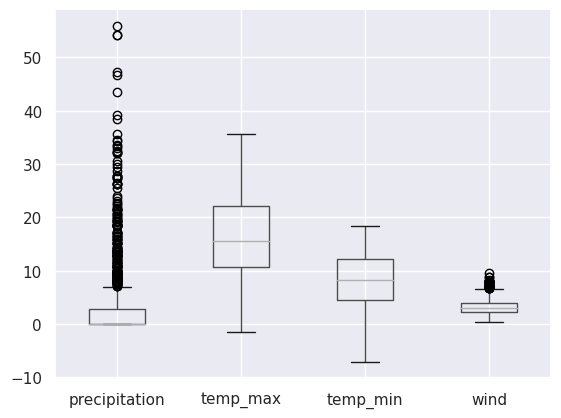

In [6]:
df.boxplot(column=['precipitation', 'temp_max', 'temp_min', 'wind'])

The precipitation column definitely has some values which are really high but it isn't just one value but a group. For this reason, I will keep these values in the dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

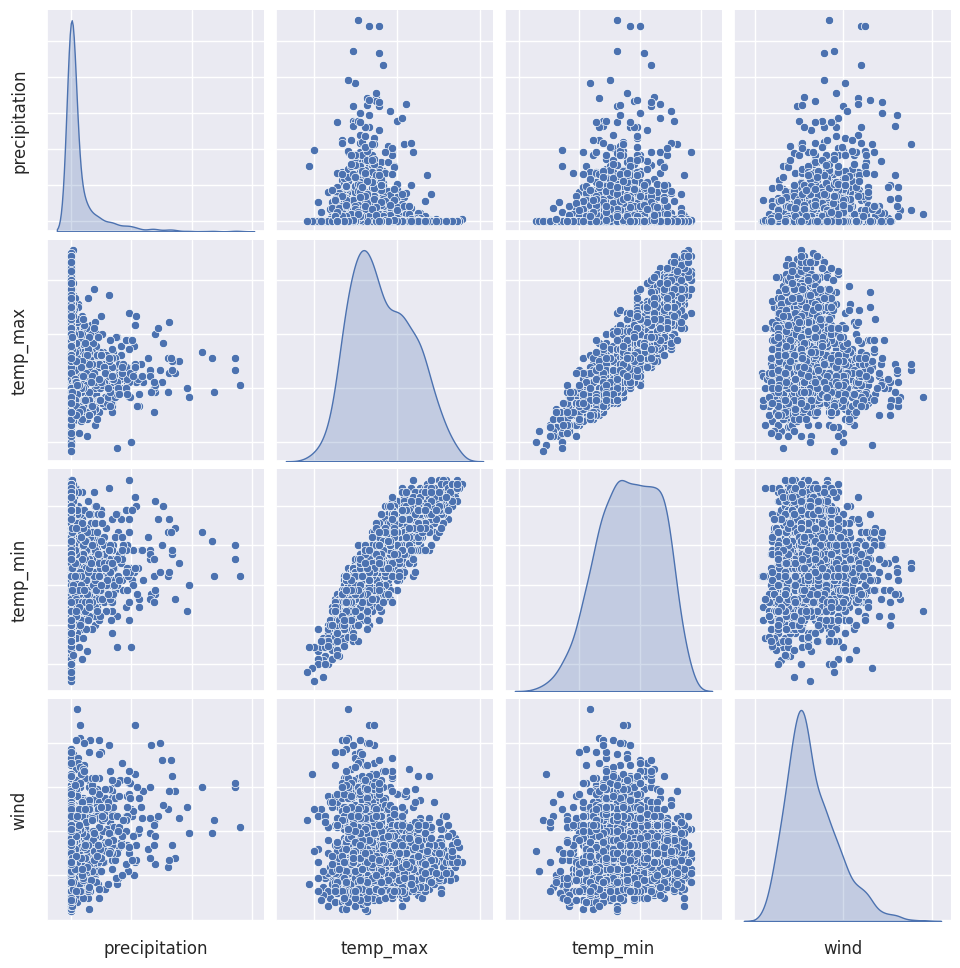

In [7]:
# Check correlations.
sns.set(font_scale=1)
pp = sns.pairplot(df, diag_kind = 'kde',\
             x_vars=['precipitation', 'temp_max', 'temp_min', 'wind'], \
             y_vars=['precipitation', 'temp_max', 'temp_min', 'wind'])
pp.set(yticklabels=[]) 
pp.set(xticklabels=[])

Text(0.5, 1.0, 'Correlation Heatmap for Weather data')

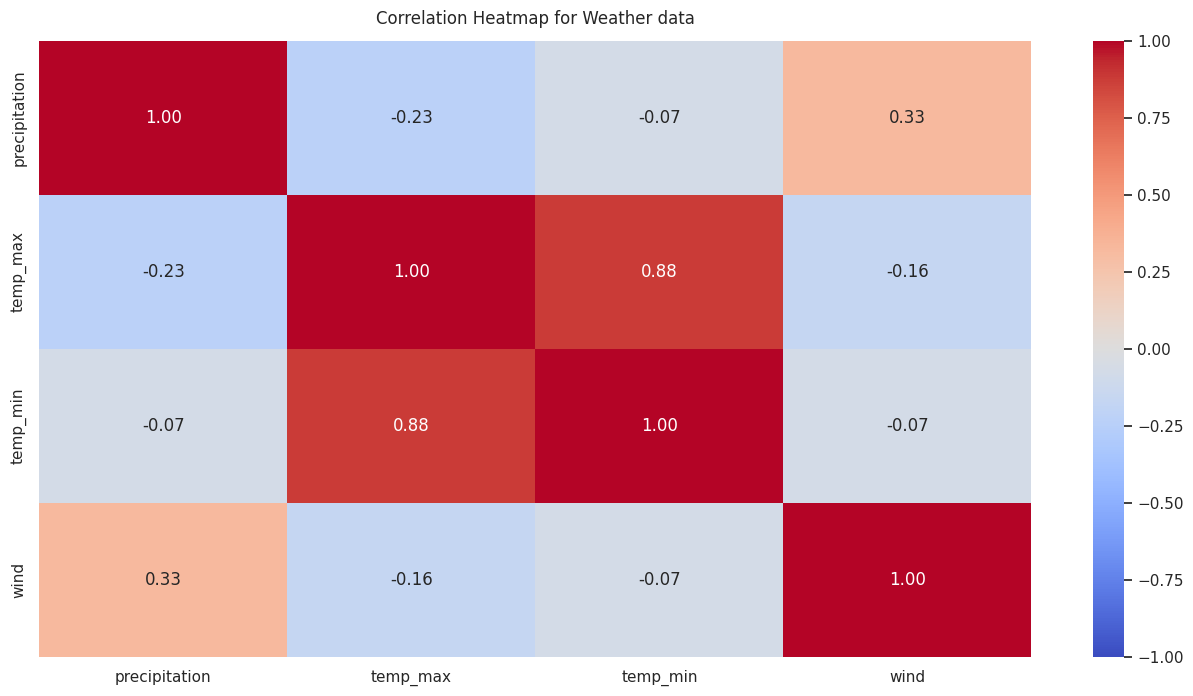

In [8]:
features = ['precipitation', 'temp_max', 'temp_min', 'wind']

# Create heatmap of correlations. 
plt.figure(figsize=(16, 8))
hp = sns.heatmap(data = df[features].corr(), vmin = -1, vmax = 1, annot=True, cmap='coolwarm', fmt='.2f')
hp.set_title('Correlation Heatmap for Weather data', fontdict={'fontsize':12}, pad=12)

Minimum and maximum temperatures are correlated but that makes sense because there are usually similar ranges between min and max temperatures throughout the day/year. 

In [9]:
# Check counts of the column we are trying to predict (weather).
df['weather'].value_counts()

weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64

Based on the counts, we can expect to predict more rain, sun, and fog. We can also expect to incorrectly predict drizzle and snow for rain, sun, and fog. This is because when we are training, there will be less cases for drizzle and snow and therefore the model will not "learn" a good pattern for when the weather is drizzle or snow. 

# Analysis

In [10]:
random.seed(12345)

# Set the data into x and y. 
features = ['precipitation', 'temp_max', 'temp_min', 'wind']
x = df[features]
y = df['weather']

# Split the data into 80% training and 20% testing datasets.  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=12345)

# View dimensions.
print("x_train:", x_train.shape)
print("x_test:",x_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

x_train: (1168, 4)
x_test: (293, 4)
y_train: (1168,)
y_test: (293,)


## Logisitic Regression

Best parameters: {'C': 100}
Best cross-validation accuracy score: 0.8433326741810032


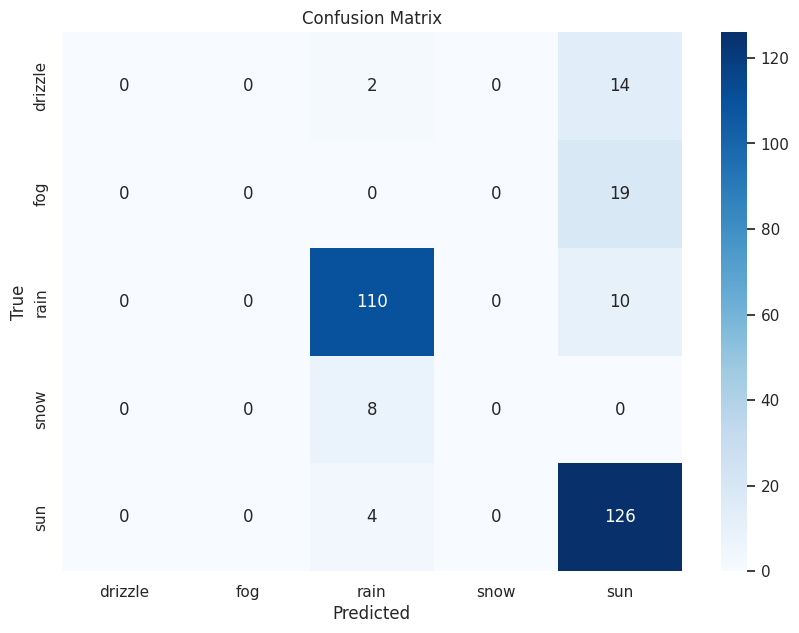

In [23]:
# Create a parameter grid. 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create model. 
lin_model = LogisticRegression(random_state=12345, solver='liblinear')

# Run all options in the parameter grid and fit the data to the best one. 
grid = GridSearchCV(lin_model, param_grid, cv=3).fit(x_train, y_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy score: {grid.best_score_}")

# Create a confusion matrix. 
conf_mat = confusion_matrix(y_test, grid.predict(x_test))

# Create a heatmap.
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')

# Add labels to the plot.
class_names = np.unique(y_test)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.title('Confusion Matrix')

plt.show()

In [25]:
# Get the accuracy, recall, precision, and f1-score to compare models. 
print("Accuracy: ", accuracy_score(y_test, grid.predict(x_test)))
print("Recall: ",recall_score(y_test, grid.predict(x_test), average=None))
print("Recall weighted average: ",recall_score(y_test, grid.predict(x_test), average='weighted'))
print("Precision: ",precision_score(y_test, grid.predict(x_test), average=None))
print("Precision weighted average: ",precision_score(y_test, grid.predict(x_test), average='weighted'))
print("F1-score: ",f1_score(y_test, grid.predict(x_test), average=None))
print("F1-score weighted average: ",f1_score(y_test, grid.predict(x_test), average='weighted'))

Accuracy:  0.8054607508532423
Recall:  [0.         0.         0.91666667 0.         0.96923077]
Recall weighted average:  0.8054607508532423
Precision:  [0.         0.         0.88709677 0.         0.74556213]
Precision weighted average:  0.694111569373047
F1-score:  [0.         0.         0.90163934 0.         0.84280936]
F1-score weighted average:  0.7432148078593167


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

Best parameters: {'max_depth': 4, 'min_samples_leaf': 6}
Best cross-validation accuracy score: 0.8527497638037485


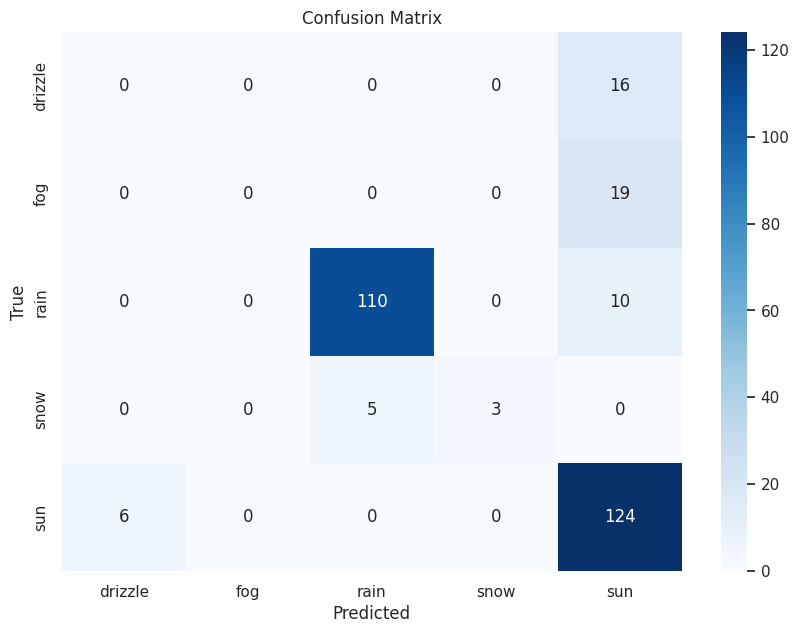

In [13]:
# Create a parameter grid. 
param_grid = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf' : [1 ,2, 4, 6, 8, 10]}
# Create model. 
tree_model = DecisionTreeClassifier(random_state=12345)

# Run all options in the parameter grid and fit the data to the best one. 
grid = GridSearchCV(tree_model, param_grid, cv=3).fit(x_train, y_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy score: {grid.best_score_}")

# Create a confusion matrix. 
conf_mat = confusion_matrix(y_test, grid.predict(x_test))

# Create a heatmap.
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')

# Add labels to the plot.
class_names = np.unique(y_test)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.title('Confusion Matrix')

plt.show()



In [14]:
# Get the accuracy, recall, precision, and f1-score to compare models. 
print("Accuracy: ", accuracy_score(y_test, grid.predict(x_test)))
print("Recall: ",recall_score(y_test, grid.predict(x_test), average=None))
print("Recall weighted average: ",recall_score(y_test, grid.predict(x_test), average='weighted'))
print("Precision: ",precision_score(y_test, grid.predict(x_test), average=None))
print("Precision weighted average: ",precision_score(y_test, grid.predict(x_test), average='weighted'))
print("F1-score: ",f1_score(y_test, grid.predict(x_test), average=None))
print("F1-score weighted average: ",f1_score(y_test, grid.predict(x_test), average='weighted'))

Accuracy:  0.8088737201365188
Recall:  [0.         0.         0.91666667 0.375      0.95384615]
Recall weighted average:  0.8088737201365188
Precision:  [0.         0.         0.95652174 1.         0.73372781]
Precision weighted average:  0.7445980344036435
F1-score:  [0.         0.         0.93617021 0.54545455 0.82943144]
F1-score weighted average:  0.7663145012016144


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## K Nearest Neighbors (KNN)

Best parameters: {'n_neighbors': 7}
Best cross-validation accuracy score: 0.7585700788785621


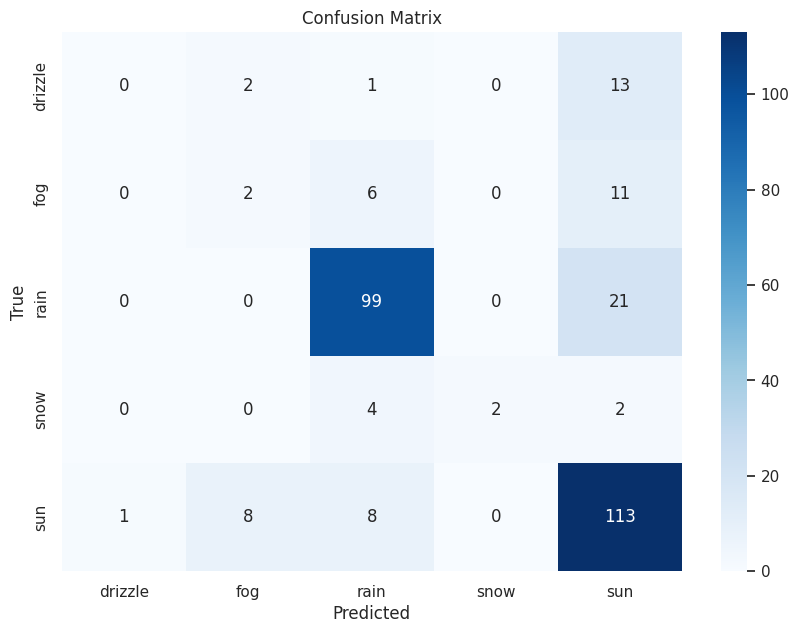

In [15]:
# Create a parameter grid.
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Create model. 
knn_model = KNeighborsClassifier(n_neighbors=5)

# Run all options in the parameter grid and fit the data to the best one. 
grid = GridSearchCV(knn_model, param_grid, cv=3).fit(x_train, y_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy score: {grid.best_score_}")

# Create a confusion matrix. 
conf_mat = confusion_matrix(y_test, grid.predict(x_test))

# Create a heatmap.
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')

# Add labels to the plot.
class_names = np.unique(y_test)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.title('Confusion Matrix')

plt.show()



In [16]:
# Get the accuracy, recall, precision, and f1-score to compare models. 
print("Accuracy: ", accuracy_score(y_test, grid.predict(x_test)))
print("Recall: ",recall_score(y_test, grid.predict(x_test), average=None))
print("Recall weighted average: ",recall_score(y_test, grid.predict(x_test), average='weighted'))
print("Precision: ",precision_score(y_test, grid.predict(x_test), average=None))
print("Precision weighted average: ",precision_score(y_test, grid.predict(x_test), average='weighted'))
print("F1-score: ",f1_score(y_test, grid.predict(x_test), average=None))
print("F1-score weighted average: ",f1_score(y_test, grid.predict(x_test), average='weighted'))

Accuracy:  0.7372013651877133
Recall:  [0.         0.10526316 0.825      0.25       0.86923077]
Recall weighted average:  0.7372013651877133
Precision:  [0.         0.16666667 0.83898305 1.         0.70625   ]
Precision weighted average:  0.695075538458572
F1-score:  [0.         0.12903226 0.83193277 0.4        0.77931034]
F1-score weighted average:  0.705781196259117


## Random Forest

Best parameters: {'max_depth': 4, 'n_estimators': 150}
Best cross-validation accuracy score: 0.8595939621646562


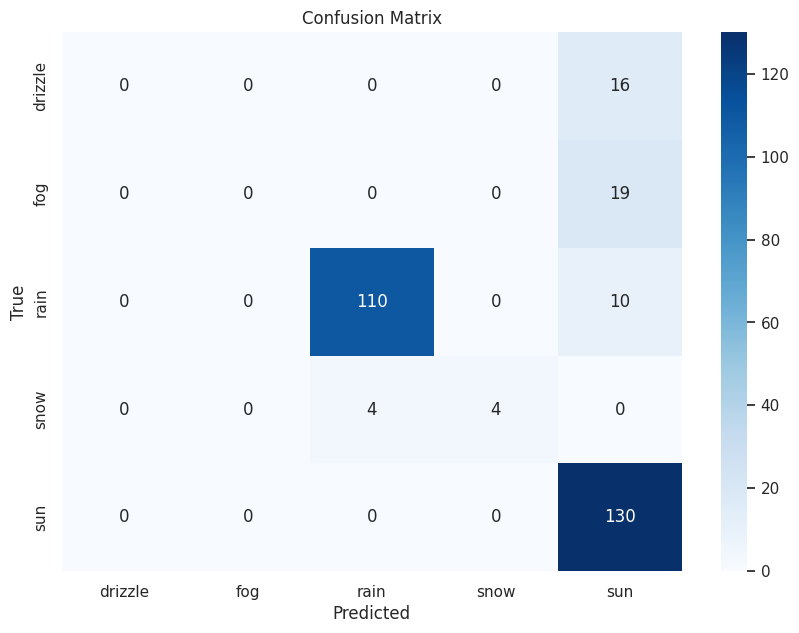

In [17]:
# Create a parameter grid.  
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [2, 4, 6, 8, 10]}

# Create model. 
rf_model = RandomForestClassifier(random_state=12345)

# Run all options in the parameter grid and fit the data to the best one. 
grid = GridSearchCV(rf_model, param_grid, cv=3).fit(x_train, y_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy score: {grid.best_score_}")

# Create a confusion matrix.
conf_mat = confusion_matrix(y_test, grid.predict(x_test))


# Create a heatmap.
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')

# Add labels to the plot.
class_names = np.unique(y_test)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.title('Confusion Matrix')

plt.show()



In [18]:
# Get the accuracy, recall, precision, and f1-score to compare models. 
print("Accuracy: ", accuracy_score(y_test, grid.predict(x_test)))
print("Recall: ",recall_score(y_test, grid.predict(x_test), average=None))
print("Recall weighted average: ",recall_score(y_test, grid.predict(x_test), average='weighted'))
print("Precision: ",precision_score(y_test, grid.predict(x_test), average=None))
print("Precision weighted average: ",precision_score(y_test, grid.predict(x_test), average='weighted'))
print("F1-score: ",f1_score(y_test, grid.predict(x_test), average=None))
print("F1-score weighted average: ",f1_score(y_test, grid.predict(x_test), average='weighted'))

Accuracy:  0.8327645051194539
Recall:  [0.         0.         0.91666667 0.5        1.        ]
Recall weighted average:  0.8327645051194539
Precision:  [0.         0.         0.96491228 1.         0.74285714]
Precision weighted average:  0.7520849906335805
F1-score:  [0.         0.         0.94017094 0.66666667 0.85245902]
F1-score weighted average:  0.7814795845904222


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Support Vector

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation accuracy score: 0.8065168193702897


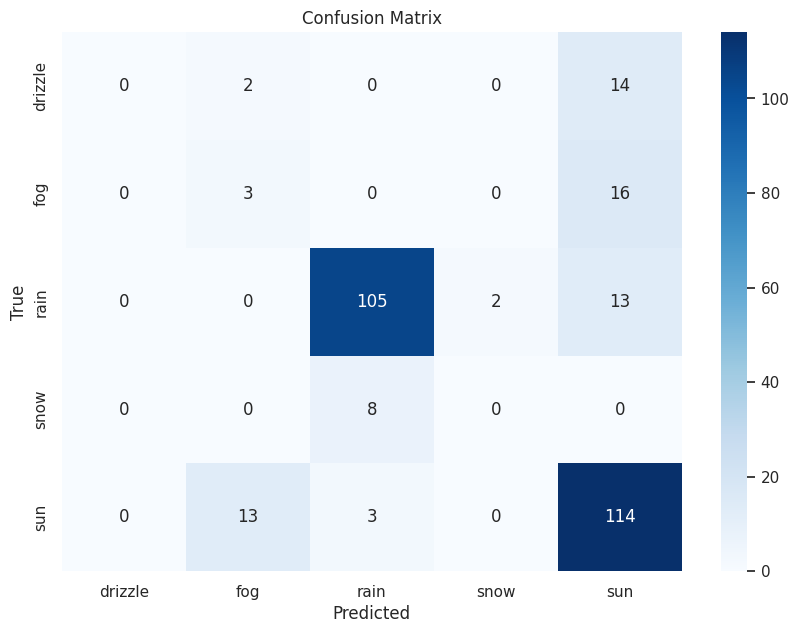

In [19]:
# Create a parameter grid. 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.1, 1, 5, 10, 100]}

# Create model. 
svc_model = SVC(random_state=12345)

# Run all options in the parameter grid and fit the data to the best one. 
grid = GridSearchCV(svc_model, param_grid, cv=3).fit(x_train, y_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation accuracy score: {grid.best_score_}")

# Create a confusion matrix. 
conf_mat = confusion_matrix(y_test, grid.predict(x_test))


# Create a heatmap.
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')

# Add labels to the plot.
class_names = np.unique(y_test)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=class_names)
plt.title('Confusion Matrix')

plt.show()



In [20]:
# Get the accuracy, recall, precision, and f1-score to compare models. 
print("Accuracy: ", accuracy_score(y_test, grid.predict(x_test)))
print("Recall: ",recall_score(y_test, grid.predict(x_test), average=None))
print("Recall weighted average: ",recall_score(y_test, grid.predict(x_test), average='weighted'))
print("Precision: ",precision_score(y_test, grid.predict(x_test), average=None))
print("Precision weighted average: ",precision_score(y_test, grid.predict(x_test), average='weighted'))
print("F1-score: ",f1_score(y_test, grid.predict(x_test), average=None))
print("F1-score weighted average: ",f1_score(y_test, grid.predict(x_test), average='weighted'))

Accuracy:  0.757679180887372
Recall:  [0.         0.15789474 0.875      0.         0.87692308]
Recall weighted average:  0.757679180887372
Precision:  [0.         0.16666667 0.90517241 0.         0.72611465]
Precision weighted average:  0.703693722800129
F1-score:  [0.         0.16216216 0.88983051 0.         0.79442509]
F1-score weighted average:  0.7274266328398364


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| Model               | Accuracy | Recall | Precision | F1-score |
|---------------------|----------|--------|-----------|----------|
| Logistic Regression | 80.55    | 80.55  | 69.41     | 74.32    |
| Decision Tree       | 80.89    | 80.89  | 74.46     | 76.63    |
| KNN                 | 73.72    | 73.72  | 69.51     | 70.58    |
| Random Forest       | 83.28    | 83.28  | 75.21     | 78.15    |
| SVC                 | 75.77    | 75.77  | 70.37     | 72.74    |


Based on the table, the random forest did the best for predicting what the weather would be based on information like precipitation, max temperature, min temperature, and wind. The random forest had the best accuracy, recall, precision, and f1-score (83.28, 83.28, 75.21, 78.15, repectively) out of all of the models tested.

This project however does not come without limitations. First, the data set size is small and certain weather did not occur often (rain: 641, sun: 640, fog: 101, drizzle: 53, snow: 26). This results in the models not being trained well when conditions of drizzle and snow arise in the test data set and often lead to misclassifications. Along with this, weather rain and sun occur much more often than other weather (fog, drizzle, and snow). This also leads to the models misclassifying testing data and reduces model performance metrics. 


Logistic regression: 

Accuracy:  0.8054607508532423

Recall:  [0.         0.         0.91666667 0.         0.96923077]

Recall weighted average:  0.8054607508532423

Precision:  [0.         0.         0.88709677 0.         0.74556213]

Precision weighted average:  0.694111569373047

F1-score:  [0.         0.         0.90163934 0.         0.84280936]

F1-score weighted average:  0.7432148078593167

Decsion tree:

Accuracy:  0.8088737201365188

Recall:  [0.         0.         0.91666667 0.375      0.95384615]

Recall weighted average:  0.8088737201365188

Precision:  [0.         0.         0.95652174 1.         0.73372781]

Precision weighted average:  0.7445980344036435

F1-score:  [0.         0.         0.93617021 0.54545455 0.82943144]

F1-score weighted average:  0.7663145012016144

KNN:

Accuracy:  0.7372013651877133

Recall:  [0.         0.10526316 0.825      0.25       0.86923077]

Recall weighted average:  0.7372013651877133

Precision:  [0.         0.16666667 0.83898305 1.         0.70625   ]

Precision weighted average:  0.695075538458572

F1-score:  [0.         0.12903226 0.83193277 0.4        0.77931034]

F1-score weighted average:  0.705781196259117

Random Forest:

Accuracy:  0.8327645051194539

Recall:  [0.         0.         0.91666667 0.5        1.        ]

Recall weighted average:  0.8327645051194539

Precision:  [0.         0.         0.96491228 1.         0.74285714]

Precision weighted average:  0.7520849906335805

F1-score:  [0.         0.         0.94017094 0.66666667 0.85245902]

F1-score weighted average:  0.7814795845904222

SVC:

Accuracy:  0.757679180887372

Recall:  [0.         0.15789474 0.875      0.         0.87692308]

Recall weighted average:  0.757679180887372

Precision:  [0.         0.16666667 0.90517241 0.         0.72611465]

Precision weighted average:  0.703693722800129

F1-score:  [0.         0.16216216 0.88983051 0.         0.79442509]

F1-score weighted average:  0.7274266328398364